In [2]:
from pathlib import Path

import causalpy as cp
import plotnine as pn
import polars as pl
import srsly
import statsmodels.formula.api as smf

In [3]:
path = Path(
    "/home/pl487/rdd/outputs/model_eval/pythia-9M-bpe32000_checkpoint-50000_2024-09-19T15-06-51/pythia-9M-bpe32000_checkpoint-50000.parquet"
)
df = pl.read_parquet(path)

In [4]:
def flatten(x: list[list]) -> list:
    return [i for j in x for i in j]


def ld_to_dl(ld: list[dict]) -> dict[str, list]:
    return {k: [dic[k] for dic in ld] for k in ld[0]}


fl = srsly.read_jsonl(
    "/home/pl487/rdd/outputs/model_eval/pythia-9M-bpe32000_checkpoint-50000_2024-09-17T17-15-44/pythia-9M-bpe32000_checkpoint-50000.jsonl"
)
df = pl.DataFrame({k: flatten(v) for k, v in ld_to_dl(line).items()} for line in fl)  # type: ignore
df = df.explode(df.columns)

In [5]:
raw_tok_path = Path("/home/pl487/rdd/outputs/tok_train/bpe_2024-09-04T12-59-54")
tok = pl.DataFrame(srsly.read_jsonl(Path(raw_tok_path) / "implemented_merges.jsonl"))

In [6]:
tok_type = "bpe"
vocab_size = 32_000

In [21]:
df

new_token_id,uid,prob_true,prob_true_and_prefix,is_out_vocab,log_prob_true,log_prob_true_and_prefix
i64,i64,list[f64],list[f64],bool,f64,f64
30681,50,"[0.000148, 0.071716]","[0.000149, 0.071716]",false,-2.635035,-2.635035
31542,84,"[0.390745, 0.000377]","[0.394534, 0.000377]",false,-7.882444,-7.882444
30689,84,"[0.000459, 0.960985]","[0.000812, 0.960985]",false,-0.039797,-0.039797
31567,84,"[0.127466, 0.03685]","[0.12751, 0.03685]",false,-3.30091,-3.30091
31120,84,"[0.630528, 0.000003]","[0.634831, 0.000003]",false,-12.886896,-12.886896
…,…,…,…,…,…,…
32202,345849,"[0.001383, 0.002486]","[0.005856, 0.002983]",true,-12.580751,-10.954995
33141,357106,"[0.000017, 0.38764]","[0.000017, 0.387924]",true,-11.93256,-11.931829
32337,377143,"[0.000125, 0.000904]","[0.000294, 0.000904]",true,-15.998172,-15.139722


In [8]:
EPS = 1e-8
df = (
    df.with_columns(is_out_vocab=pl.col("new_token_id") >= vocab_size).with_columns(
        log_prob_true=(
            # For token out-of-vocab...
            pl.when(pl.col("is_out_vocab"))
            # ...keep probs of both tokens creating the merge...
            .then(pl.col("prob_true"))
            # ...and for those in-vocab only keep the prob of the token itself
            .otherwise(pl.col("prob_true").list.slice(-1, 1))
            # Compute the log-prob
            .list.eval((pl.element() + EPS).log())
            # Sum it to get the log-prob of the merge (for in-vocab is simply log-prob of token)
            .list.sum()
        ),
        log_prob_true_and_prefix=(
            # For token out-of-vocab...
            pl.when(pl.col("is_out_vocab"))
            # ...keep probs of both tokens creating the merge...
            .then(pl.col("prob_true_and_prefix"))
            # ...and for those in-vocab only keep the prob of the token itself
            .otherwise(pl.col("prob_true_and_prefix").list.slice(-1, 1))
            # Compute the log-prob
            .list.eval((pl.element() + EPS).log())
            # Sum it to get the log-prob of the merge (for in-vocab is simply log-prob of token)
            .list.sum()
        ),
    )
    # .with_columns(pl.col("tok_prob_true").list.len())["tok_prob_true"].value_counts()
)

/home/pl487/rdd/.venv/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 145'. Pick better value with 'binwidth'.


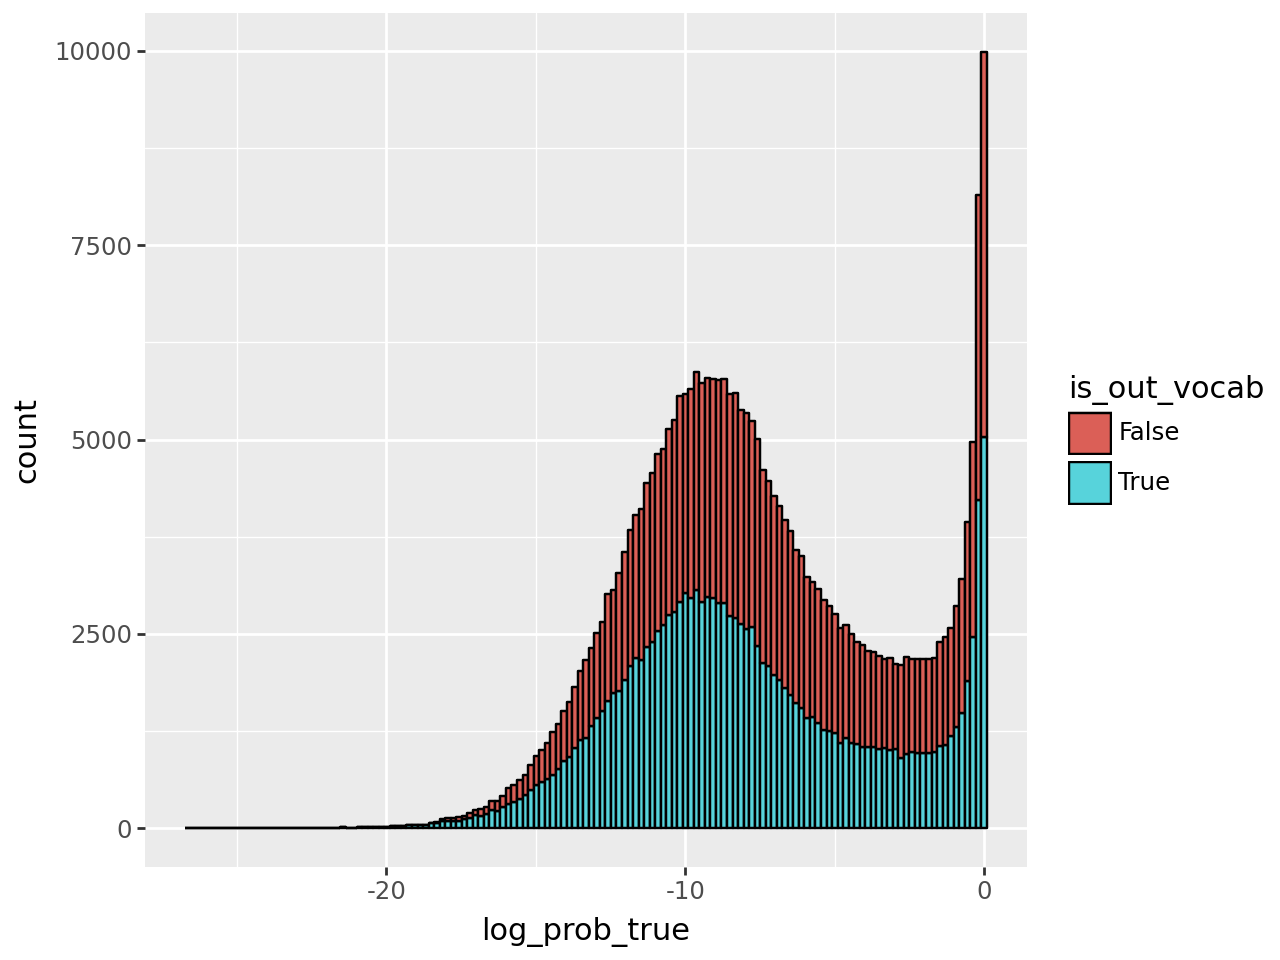

In [27]:
(pn.ggplot(df, pn.aes("log_prob_true", fill="is_out_vocab")) + pn.geom_histogram(colour="black"))

In [11]:
# Compute average log-prob per token across contexts
avg_df = df.group_by(["new_token_id", "is_out_vocab"]).agg(
    pl.col("log_prob_true").mean(), pl.col("log_prob_true_and_prefix").mean()
)

In [12]:
avg_df = avg_df.join(tok.select(["new_token_id", "count"]), on="new_token_id")

In [13]:
# for idx, col in enumerate(df.columns):
#     if df.dtypes[idx] not in (pl.Boolean, pl.List):
#         print(col, df[col].is_infinite().sum())

In [14]:
# Prepare for regression making the scale more compatible
avg_df = avg_df.with_columns(pl.col("new_token_id") / 1_000)

In [15]:
avg_df.head()

new_token_id,is_out_vocab,log_prob_true,log_prob_true_and_prefix,count
f64,bool,f64,f64,i64
30.5,false,-10.100871,-10.100871,26573
30.501,false,-7.632609,-7.632609,26569
30.502,false,-7.364385,-7.364385,26564
30.503,false,-2.17339,-2.17339,26563
30.504,false,-8.55066,-8.55066,26562


In [19]:
# Fit model
# rdd = smf.ols("log_prob_true ~ new_token_id + is_out_vocab + new_token_id:is_out_vocab", avg_df.to_pandas()).fit(cov_type="HC3")
rdd = smf.ols("log_prob_true ~ count + is_out_vocab + count:is_out_vocab", avg_df.to_pandas()).fit(cov_type="HC3")

# Compute discontinuity at threasold
# discontinuity_at_threshold = rdd.predict({"new_token_id": [31.999, 32.0], "is_out_vocab": [False, True]}).to_dict()
# discontinuity_at_threshold = discontinuity_at_threshold[1] - discontinuity_at_threshold[0]
# print(discontinuity_at_threshold)

rdd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_prob_true   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     16.20
Date:                Thu, 19 Sep 2024   Prob (F-statistic):           1.92e-10
Time:                        15:17:45   Log-Likelihood:                -6956.6
No. Observations:                2993   AIC:                         1.392e+04
Df Residuals:                    2989   BIC:                         1.395e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -8.1528      2.758     -2.956      0.003     -13.559      -2.747
is_out_vocab[T.True]          -5.2416      3.999     -1.311      0.190     -13.079       2.596
count                       3.676e-05      0.000      0.339      0.734      -0.000       0.000
count:is_out_vocab[T.True]     0.0002      0.000      1.222      0.222      -0.000       0.001
==============================================================================
Omnibus:                      290.234   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.711
Skew:                           0.875   Prob(JB):                     1.30e-83
Kurtosis:                       3.036   Cond. No.                     2.71e+06
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 2.71e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

0      -7.176079
1      -7.176226
2      -7.176410
3      -7.176447
4      -7.176484
          ...   
2988   -8.022973
2989   -8.023211
2990   -8.023448
2991   -8.023448
2992   -8.023922
Length: 2993, dtype: float64

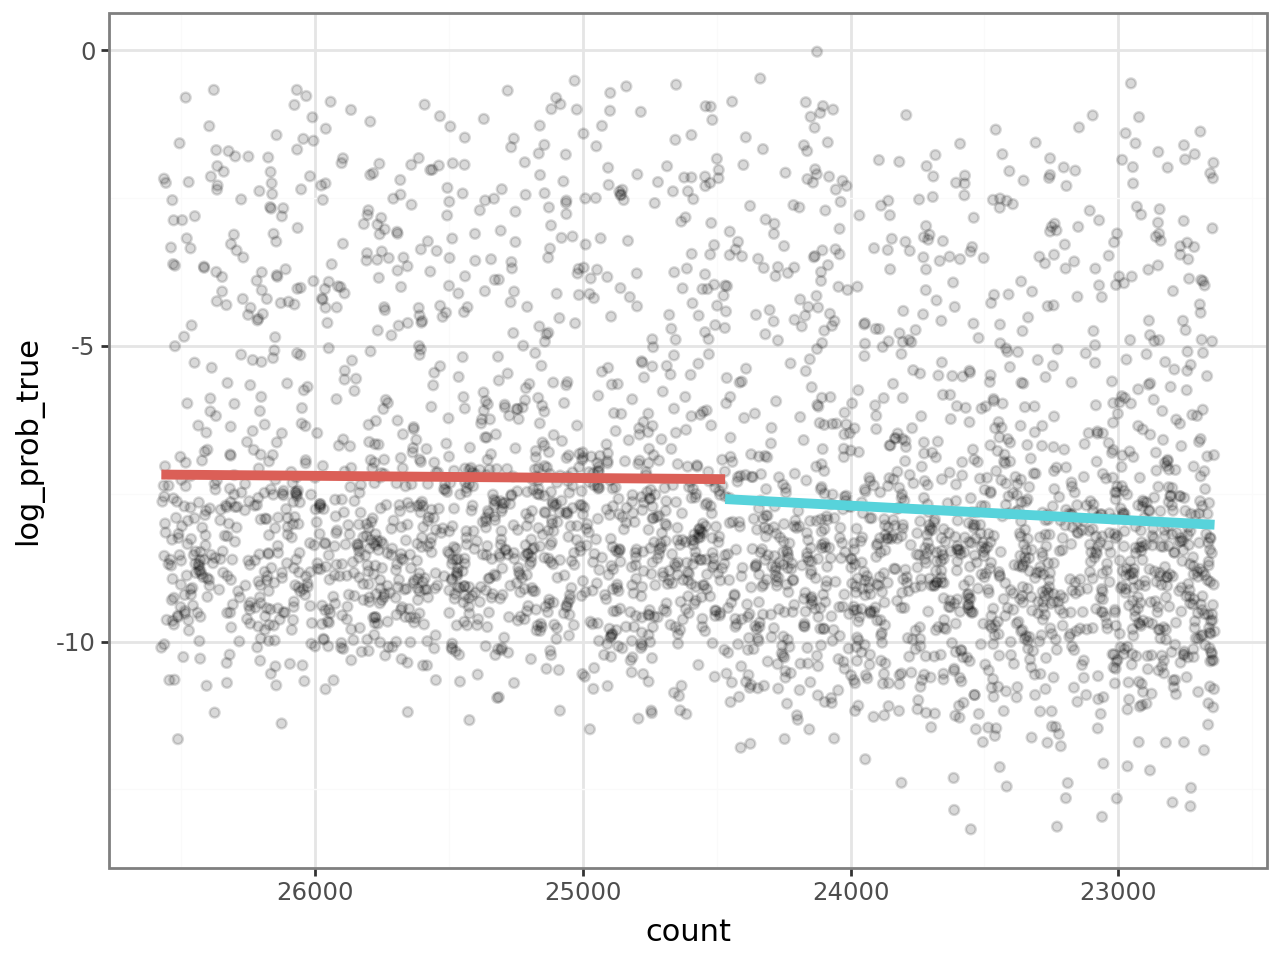

In [20]:
p = (
    pn.ggplot(avg_df, pn.aes(x="count", y="log_prob_true"))
    + pn.geom_point(alpha=0.15)
    + pn.geom_line(pn.aes(y=rdd.fittedvalues, color="is_out_vocab"), size=2)
    # pn.coord_cartesian(ylim=(4, 12)) +
    # + pn.geom_vline(xintercept=vocab_size / 1000, linetype="dashed", color="black")
    + pn.scale_x_reverse()
    # + pn.labs(x="", y="", colour="", title=f"Discontinuity at threshold: {discontinuity_at_threshold:.2f}")
    + pn.scale_colour_discrete(guide=None)
    + pn.theme_bw()
    # pn.scale_y_log10()
)

p

In [76]:
# Fit model
rdd = smf.ols(
    "log_prob_true_and_prefix ~ new_token_id + is_out_vocab + new_token_id:is_out_vocab", avg_df.to_pandas()
).fit(cov_type="HC3")

# Compute discontinuity at threasold
discontinuity_at_threshold = rdd.predict({"new_token_id": [31.999, 32.0], "is_out_vocab": [False, True]}).to_dict()
discontinuity_at_threshold = discontinuity_at_threshold[1] - discontinuity_at_threshold[0]
print(discontinuity_at_threshold)

rdd.summary()

-9.994307865796827


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     log_prob_true_and_prefix   R-squared:                       0.611
Model:                                  OLS   Adj. R-squared:                  0.611
Method:                       Least Squares   F-statistic:                     1560.
Date:                      Tue, 17 Sep 2024   Prob (F-statistic):               0.00
Time:                              12:36:17   Log-Likelihood:                -8356.8
No. Observations:                      2993   AIC:                         1.672e+04
Df Residuals:                          2989   BIC:                         1.675e+04
Df Model:                                 3                                         
Covariance Type:                        HC3                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -13.7875      4.695     -2.937      0.003     -22.989      -4.586
is_out_vocab[T.True]                 -7.7385     11.060     -0.700      0.484     -29.415      13.938
new_token_id                          0.1023      0.150      0.681      0.496      -0.192       0.397
new_token_id:is_out_vocab[T.True]    -0.0705      0.341     -0.207      0.836      -0.738       0.597
==============================================================================
Omnibus:                       36.762   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               63.804
Skew:                           0.015   Prob(JB):                     1.40e-14
Kurtosis:                       3.715   Cond. No.                     6.20e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 6.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

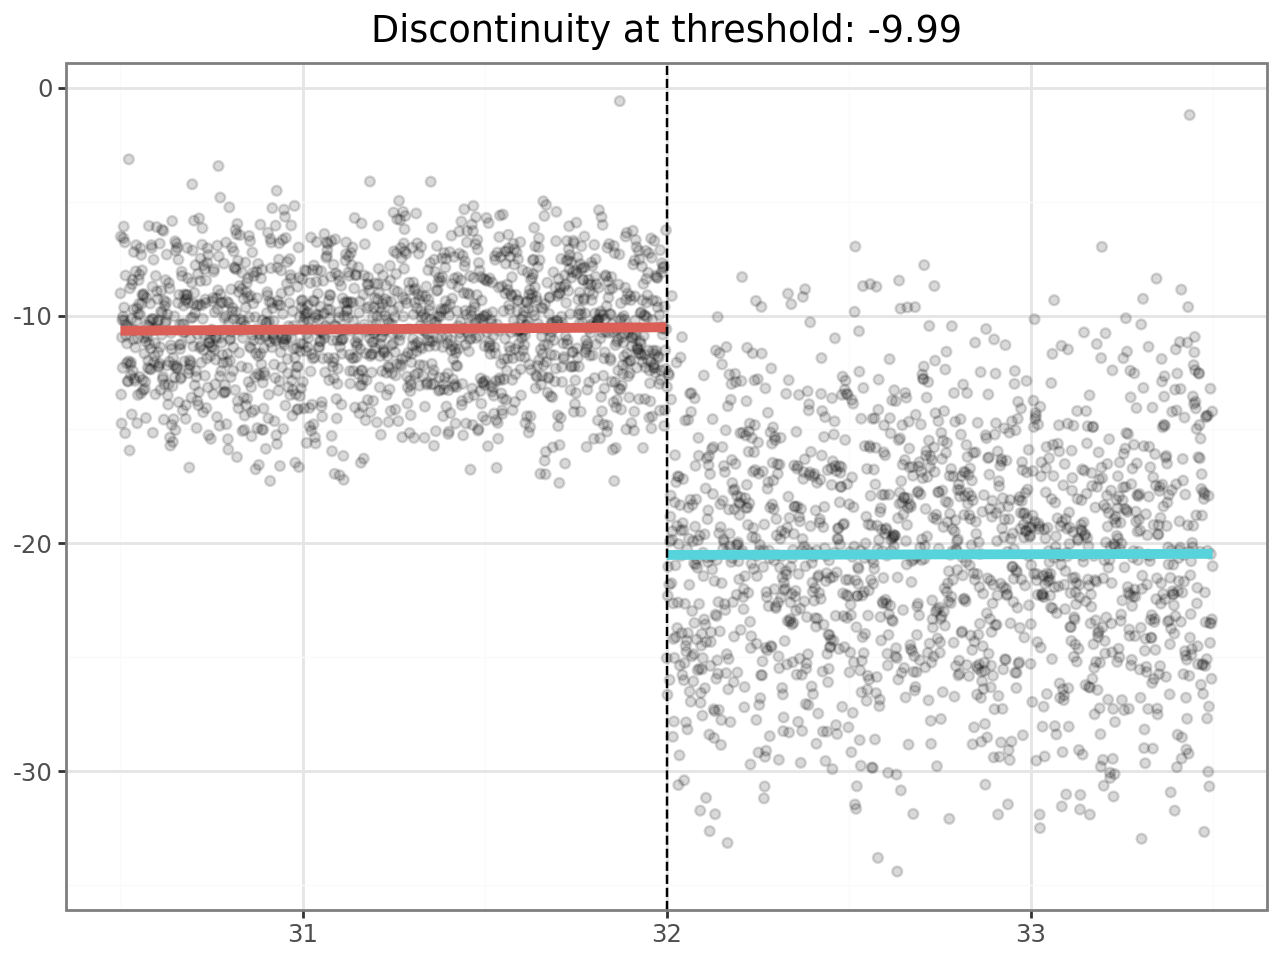

In [77]:
p = (
    pn.ggplot(avg_df, pn.aes(x="new_token_id", y="log_prob_true_and_prefix"))
    + pn.geom_point(alpha=0.15)
    + pn.geom_line(pn.aes(y=rdd.fittedvalues, color="is_out_vocab"), size=2)
    # pn.coord_cartesian(ylim=(4, 12)) +
    + pn.geom_vline(xintercept=vocab_size / 1000, linetype="dashed", color="black")
    + pn.labs(x="", y="", colour="", title=f"Discontinuity at threshold: {discontinuity_at_threshold:.2f}")
    + pn.scale_colour_discrete(guide=None)
    + pn.theme_bw()
    # pn.scale_y_log10()
)

p

----

In [102]:
from sklearn.linear_model import LinearRegression

result = cp.RegressionDiscontinuity(
    data=avg_df.to_pandas().rename(columns={"is_out_vocab": "treated"}),
    formula="log_prob_true ~ 1 + new_token_id + treated",
    model=LinearRegression(),
    treatment_threshold=vocab_size / 1_000,
    running_variable_name="new_token_id",
)

# fig, ax = result.plot()

(<Figure size 720x480 with 1 Axes>,
 <Axes: title={'center': '$R^2$ on all data = 0.7\nDiscontinuity at threshold = -12'}, xlabel='new_token_id', ylabel='log_prob_true'>)

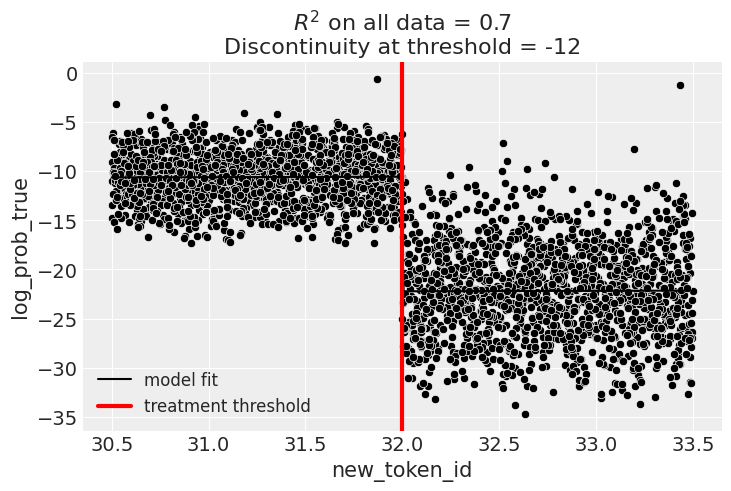

In [108]:
result.plot()

In [109]:
result.summary()

Difference in Differences experiment
Formula: log_prob_true ~ 1 + new_token_id + treated
Running variable: new_token_id
Threshold on running variable: 32.0

Results:
Discontinuity at threshold = -11.66


Model coefficients:
  Intercept      	         0
  treated[T.True]	       -12
  new_token_id   	     0.047


In [110]:
result.print_coefficients()

Model coefficients:
  Intercept      	         0
  treated[T.True]	       -12
  new_token_id   	     0.047
